# End of life variability definitions

Andrew Weng

1/4/2022

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import glob, re, pprint, random

from scipy.stats import pearsonr, ttest_ind, norm
from scipy.signal import savgol_filter
from scipy import interpolate

from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from src.formation import FormationCell
from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 24
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

## Define the empirical lifetime models

In [3]:
lin1   = lambda t, c1         : 100 - c1 * t
lin2   = lambda t, B0, c2     : B0  - c2 * t
linexp = lambda t, c1, tf, tau: 100 - c1 * t - np.exp((t - tf) / tau)

## Do the computations

In [4]:
# Sample size
num_points = 5000
num_points_to_plot = 100

# For end of life variability calcs
time_target = 20     # days
capacity_target = 70 # %

# Model parameter statistics
c1_vec = np.random.normal(0.025, 0.0015, num_points)
c1_vec[c1_vec > 100] = 100
tf_vec = np.random.normal(1000, 100, num_points)
tau_vec = np.random.normal(80, 10, num_points)

### Vertical Slices

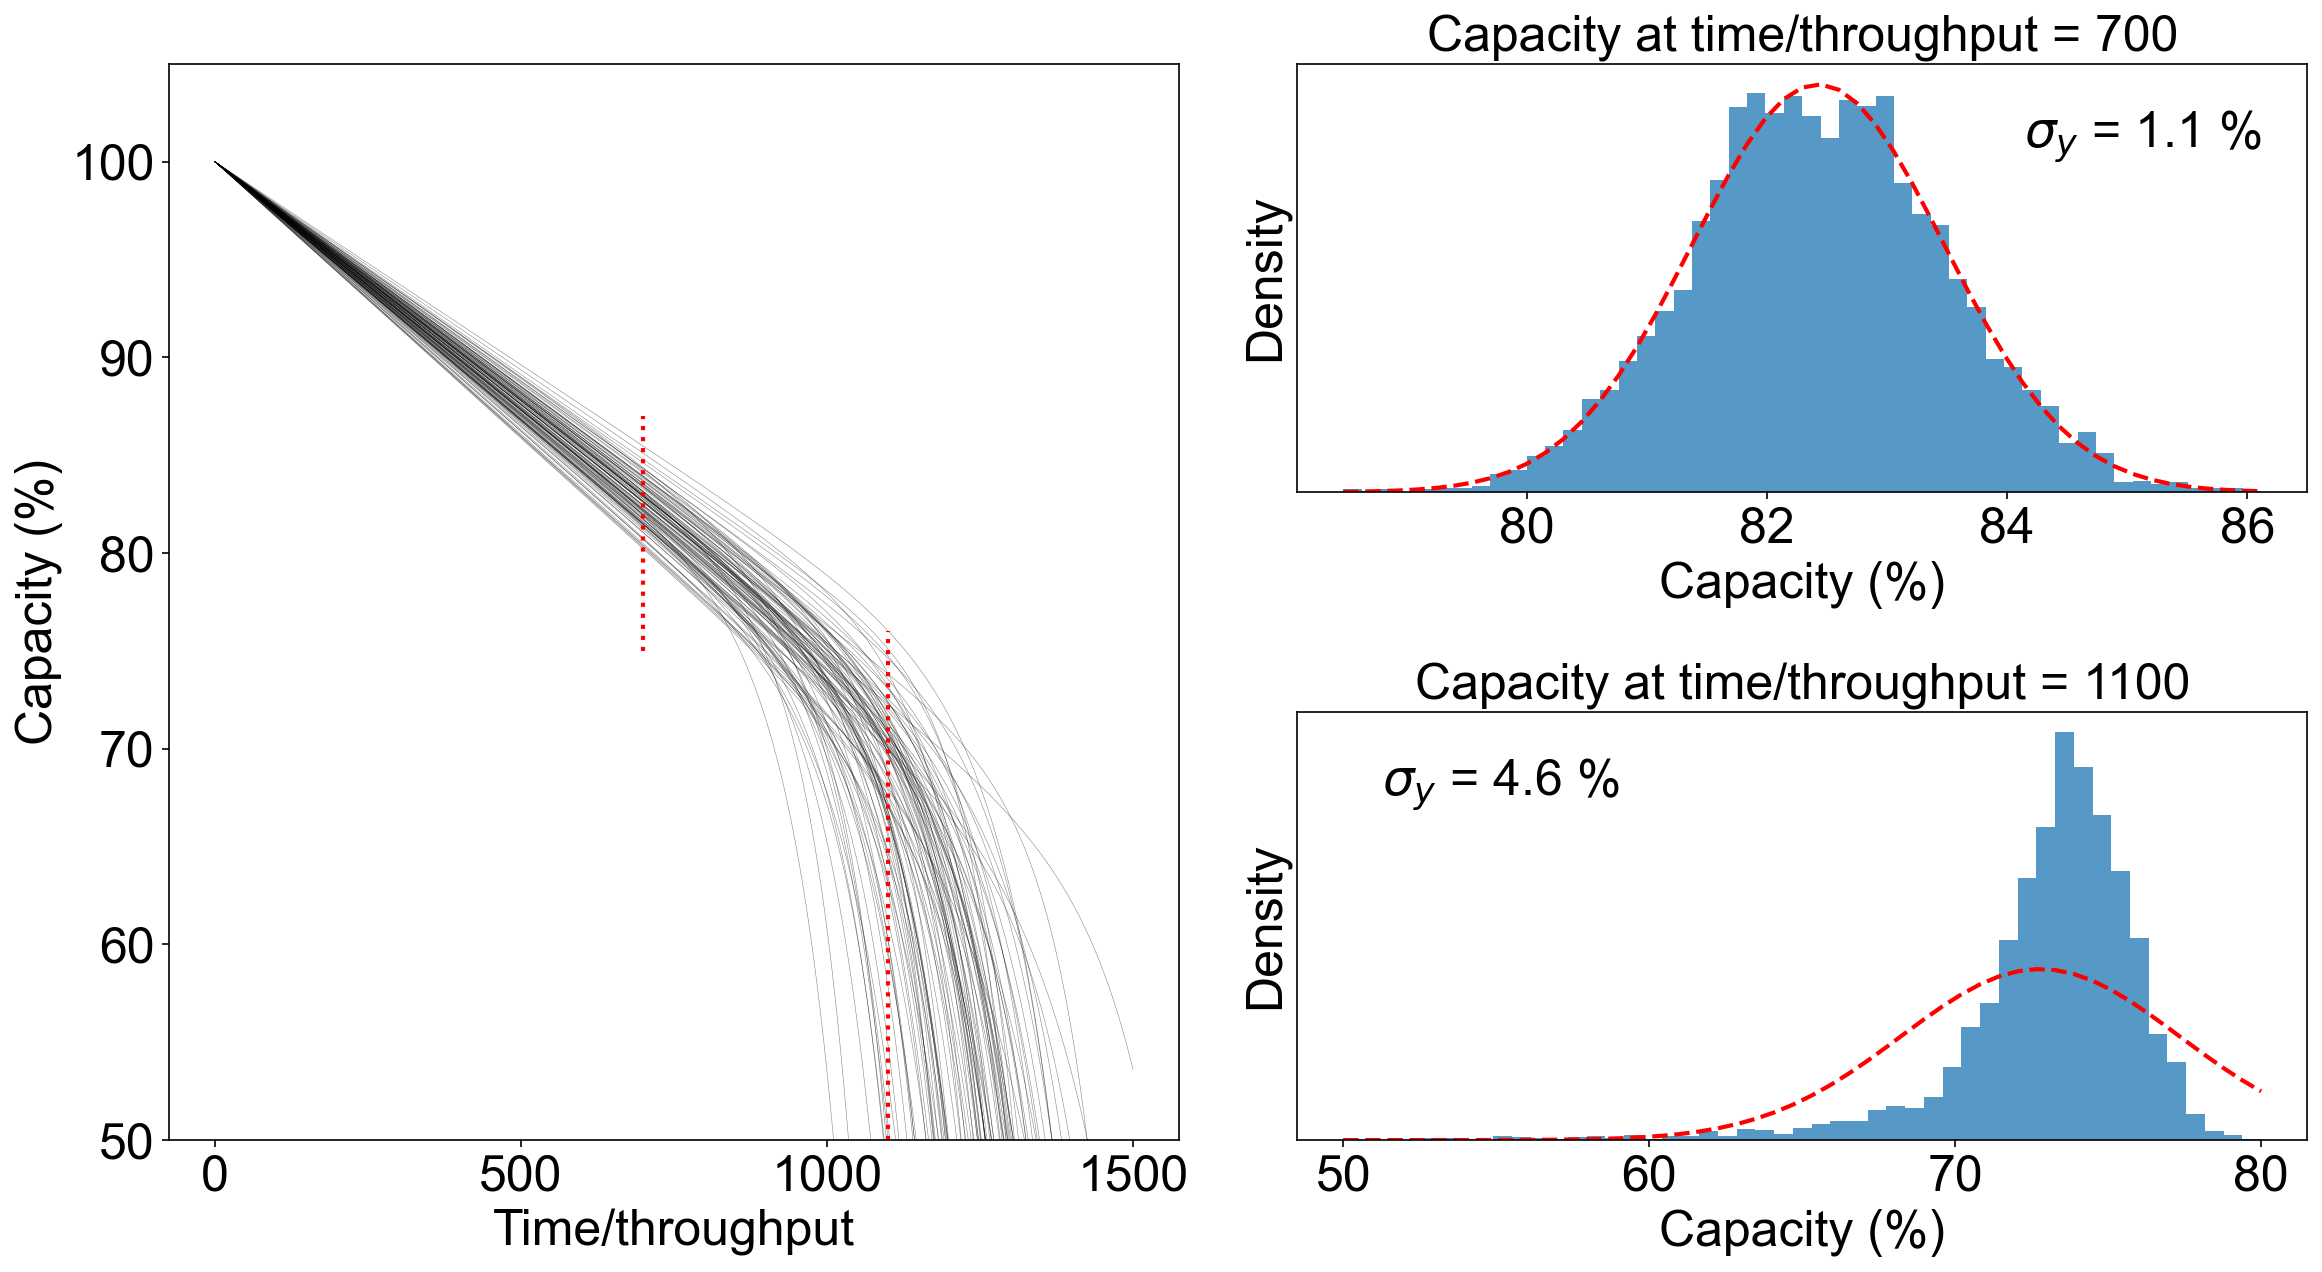

In [18]:
t = np.linspace(0, 1500, 1000)

plt.figure(figsize=(16,9))

plt.subplot(121)
capacity_at_day_target_1 = []
capacity_at_day_target_2 = []
time_to_capacity_target_1 = []
time_to_capacity_target_2 = []
time_target_1 = 700
time_target_2 = 1100
counter = 0

np.random.seed()


for c1, tf, tau in zip(c1_vec, tf_vec, tau_vec):
    
    B = linexp(t, c1, tf, tau)
    capacity_at_day_target_1.append(linexp(700, c1, tf, tau))
    capacity_at_day_target_2.append(linexp(1000, c1, tf, tau))

    f_inv = interpolate.interp1d(B, t)
    time_to_capacity_target_1.append(float(f_inv(80)))
    time_to_capacity_target_2.append(float(f_inv(70)))

    if counter % (num_points / num_points_to_plot) == 0:
        plt.plot(t, B, linestyle='-', linewidth=0.25, color='k', alpha=0.5)
    
    counter += 1 
    
capacity_at_day_target_2 = np.array(capacity_at_day_target_2)
capacity_at_day_target_2[capacity_at_day_target_2 < 0] = 0

plt.plot([time_target_1, time_target_1], [75, 87], linestyle=':', color='r', linewidth=2)
plt.plot([time_target_2, time_target_2], [50, 76], linestyle=':', color='r', linewidth=2)

plt.ylim((50, 105))
plt.xlabel('Time/throughput')
plt.ylabel('Capacity (%)')

(mu, sigma) = norm.fit(capacity_at_day_target_1)

plt.subplot(222)
n, bins, _ = plt.hist(capacity_at_day_target_1, 50, 
                      density=True,
                      alpha=0.75);

y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Capacity (%)')
plt.ylabel('Density')
plt.yticks([])
plt.title(f'Capacity at time/throughput = {time_target_1}')
plt.legend([f"$\sigma_y$ = {sigma:.1f} %"], frameon=False, handlelength=0)

plt.subplot(224)

(mu, sigma) = norm.fit(capacity_at_day_target_2)
n, bins, _ = plt.hist(capacity_at_day_target_2, np.linspace(50, 80, 50), 
                      density=True,
                      alpha=0.75);

y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Capacity (%)')
plt.ylabel('Density')
plt.yticks([])
plt.title(f'Capacity at time/throughput = {time_target_2}')
plt.legend([f"$\sigma_y$ = {sigma:.1f} %"], frameon=False, handlelength=0)

plt.savefig('vertical_slice.png', format='png', dpi=600)

### Horizontal Slices

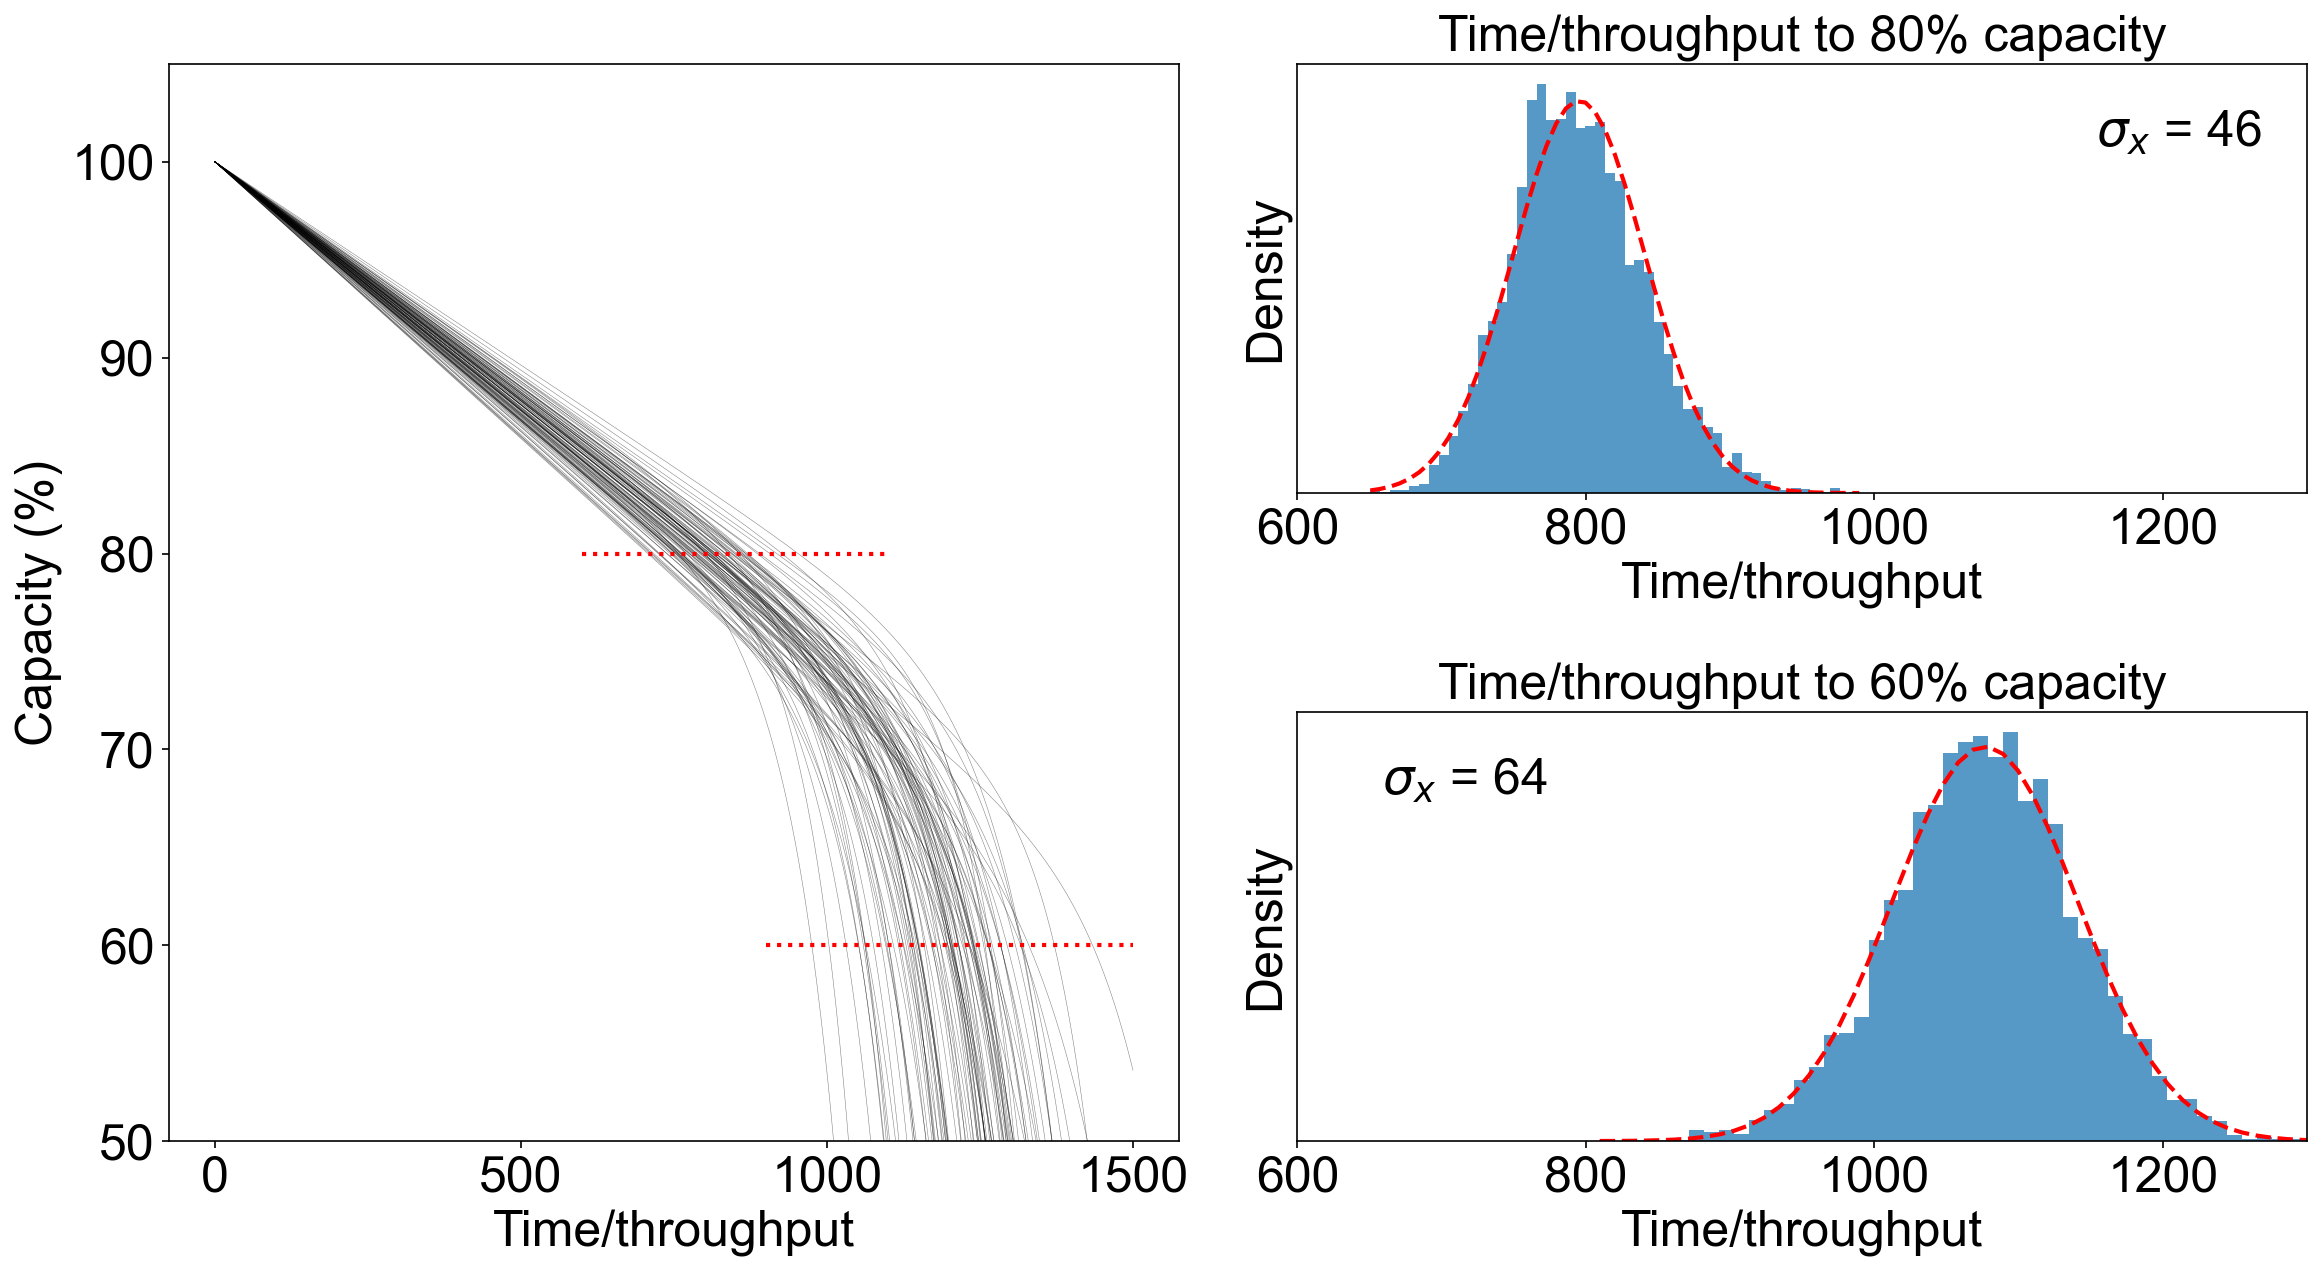

In [17]:
t = np.linspace(0, 1500, 1000)

plt.figure(figsize=(16,9))

plt.subplot(121)

capacity_at_day_target_1 = []
capacity_at_day_target_2 = []
time_to_capacity_target_1 = []
time_to_capacity_target_2 = []
time_target_1 = 700
time_target_2 = 1100
capacity_target_1 = 80
capacity_target_2 = 60
counter = 0

np.random.seed()

for c1, tf, tau in zip(c1_vec, tf_vec, tau_vec):
    
    B = linexp(t, c1, tf, tau)
    capacity_at_day_target_1.append(linexp(700, c1, tf, tau))
    capacity_at_day_target_2.append(linexp(1000, c1, tf, tau))

    f_inv = interpolate.interp1d(B, t)
    time_to_capacity_target_1.append(float(f_inv(80)))
    time_to_capacity_target_2.append(float(f_inv(70)))

    if counter % (num_points / num_points_to_plot) == 0:
        plt.plot(t, B, linestyle='-', linewidth=0.25, color='k', alpha=0.5)
    
    counter += 1 
    
capacity_at_day_target_2 = np.array(capacity_at_day_target_2)
capacity_at_day_target_2[capacity_at_day_target_2 < 0] = 0

plt.plot([600, 1100], [capacity_target_1, capacity_target_1], linestyle=':', color='r', linewidth=2)
plt.plot([900, 1500], [capacity_target_2, capacity_target_2], linestyle=':', color='r', linewidth=2)

plt.ylim((50, 105))
plt.xlabel('Time/throughput')
plt.ylabel('Capacity (%)')

(mu, sigma) = norm.fit(time_to_capacity_target_1)

plt.subplot(222)
n, bins, _ = plt.hist(time_to_capacity_target_1, 50, 
                      density=True,
                      alpha=0.75);

y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlim((600, 1300))
plt.xlabel('Time/throughput')
plt.ylabel('Density')
plt.yticks([])
plt.title(f'Time/throughput to {capacity_target_1}% capacity')
plt.legend([f"$\sigma_x$ = {sigma:.0f}"], frameon=False, handlelength=0)

plt.subplot(224)

(mu, sigma) = norm.fit(time_to_capacity_target_2)
n, bins, _ = plt.hist(time_to_capacity_target_2, 50,
                      density=True,
                      alpha=0.75);

y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlim((600, 1300))
plt.xlabel('Time/throughput')
plt.ylabel('Density')
plt.yticks([])
plt.title(f'Time/throughput to {capacity_target_2}% capacity')
plt.legend([f"$\sigma_x$ = {sigma:.0f}"], frameon=False, handlelength=0)


plt.savefig('horizontal_slice.png', format='png', dpi=600)